In [1]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import io
import PIL.Image, PIL.ImageDraw

import requests

import numpy as np
import jax
import jax.numpy as jnp
import jax
from jax import jit, grad, lax
import optax
import haiku as hk

import matplotlib.pyplot as plt
import tqdm

from IPython.display import Image, clear_output

In [2]:
TARGET_SIZE = 40

def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.Resampling.LANCZOS)
  img = jnp.float32(img) / 255.0

  # premultiply RGB by Alpha
  img.at[..., :3].set(img[..., 3:])
  # img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  # code = hex(ord(emoji)).a.lower()
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)

def np2pil(a):
  if a.dtype in [jnp.float32, jnp.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = jnp.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = jnp.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def to_rgba(x):
  "This function used outside model, using original shaping conventions"
  return x[..., :4] # may need to change for JAX's immutability


In [3]:
# Parameters

TARGET_PADDING = 16

CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

# Load target image
target_img = load_emoji(TARGET_EMOJI)

In [4]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0)]

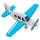

In [13]:
imshow(target_img)

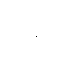

In [14]:
# Make seed image
p = TARGET_PADDING
pad_target = jnp.pad(target_img, ((p, p), (p, p), (0, 0)))
h, w = pad_target.shape[:2]
seed = jnp.zeros((h, w, CHANNEL_N), jnp.float32)
seed = seed.at[h//2, w//2, 3:].set(1)
x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0) # batch it up
imshow(seed[..., :4])

In [47]:
def f(a, b):
    return a + b
print(type(f))
f = hk.transform(f)
print(type(f))
params = f.init(None, 1, 2)
f.apply(params, None, 2)

<class 'function'>
<class 'haiku._src.transform.Transformed'>


TypeError: f() missing 1 required positional argument: 'b'

In [30]:
# https://github.com/deepmind/dm-haiku#quickstart

# Define CA model

class CAModel(hk.Module):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE, name=None):
    super().__init__(name=name) # follow documented convention by passing in `name`
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.model = hk.Sequential([
        hk.Conv2D(output_channels=128, kernel_shape=1),
        jax.nn.relu,
        # initalize the below weights to zero
        hk.Conv2D(output_channels=CHANNEL_N, kernel_shape=1),
        # no activation function
    ])

  def perceive(self, x,):
    identify = jnp.float32([0, 1, 0])
    identify = jnp.outer(identify, identify)
    dx = jnp.outer(jnp.float32([1, 2, 1]), \
                  jnp.float32([-1, 0, 1])) / 8.0  # Sobel filter
    dy = dx.T
    kernel = jnp.stack([identify, dx, dy], -1)[:, :, None, :]
    kernel = jnp.repeat(kernel, 16, axis=2)

    # kernel should be reshaped from [filter_height, filter_width, in_channels, channel_multiplier] to 
    # [filter_height, filter_width, 1, in_channels * channel_multiplier] per
    # https://www.tensorflow.org/xla/operation_semantics
    kernel_reshaped = kernel.reshape((3, 3, 1, 48))
    # dimension_numbers specify shape of input, kernel, and output tensors
    y = lax.conv_general_dilated(x0, kernel_reshaped, window_strides=(1, 1), padding="SAME",  feature_group_count=16,\
                                dimension_numbers=('NHWC', 'HWIO', 'NHWC'))
    return y

  def __call__(self, x):

    # Perceive neighbourhood
    y = self.perceive(x)

    # Pass through model
    dx = self.model(y)
    return x + dx


In [31]:
def lift_model(x):
  model = CAModel()
  return model(x)

# Make an object with `init` and `apply` methods
ca_model = hk.transform(lift_model)

key = hk.PRNGSequence(22)
initial_params = ca_model.init(next(key), x0)
# print(type(params), params)
y = ca_model.apply(initial_params, None, x0)

# print(x0.shape)
# print(y.shape)
# print(pad_target.shape)

In [32]:
print(pad_target.shape)
seed.shape

(72, 72, 4)


(72, 72, 16)

In [33]:
def loss_f(prediction, target):
  return optax.l2_loss(to_rgba(prediction), target)

def loss_f1(prediction, target):
  return jnp.mean(jnp.square(to_rgba(prediction) - target), axis=[-2, -3, -1])

loss = loss_f(seed, pad_target)
print(loss.shape)

xtest = jnp.ones((8, 72, 72, 4))
loss1 = loss_f1(xtest, pad_target)
print(seed.shape, loss1.shape)
print(loss1)

x = jnp.ones((72, 72, 4))
xloss = loss_f(x, pad_target)

# print(jnp.allclose(loss, loss1))

(72, 72, 4)
(72, 72, 16) (8,)
[0.8783978 0.8783978 0.8783978 0.8783978 0.8783978 0.8783978 0.8783978
 0.8783978]


In [34]:
# Training sequence (no class this time)

def loss_f(prediction, target):
  return jnp.mean(jnp.square(to_rgba(prediction) - target), axis=[-2, -3, -1]).mean()

def update(x, model, model_params, optimizer, optimizer_state):
  """This is where the actual learning happens"""
  grads = jax.grad(loss_f)(x, pad_target)
  print(f'grads is: {type(grads)}\
    and optimizer state is {type(optimizer_state)}')
  # print(f'grads: {grads}')
  updates, optimizer_state = optimizer.update(grads, optimizer_state, model_params)
  model_params = optax.apply_updates(model_params, updates)
  return model_params, optimizer_state, 

def train_step(x, model, model_params, \
               optimizer, optimizer_state):
  iter_n = np.random.randint(64, 97, dtype=np.int32)
  for _ in range(iter_n):
    x = model.apply(model_params, None, x)
  
  # Update model params
  model_params, optimizer_state = update(x, model, model_params, \
                                         optimizer, optimizer_state)
  
def train(x0, model, model_params, \
          optimizer, optimizer_state, n_train_steps=1000+1):
  
  for i in range(n_train_steps):
    x, loss = train_step(x0, model, model_params, \
                         optimizer, optimizer_state)

    if i % 100 == 0:
      clear_output()

      # visualize batch
      # plot loss
      # expot model (if desired)
    print('\r step: %d, log10(loss): %.3f'%(i, np.log10(loss)), end='')


In [35]:
def lift_model(x):
  model = CAModel()
  return model(x)

# Make an object with `init` and `apply` methods
ca_model = hk.transform(lift_model)

key = hk.PRNGSequence(22)
initial_params = ca_model.init(next(key), x0)
# print(type(params), params)
# y = ca_model.apply(initial_params, None, x0)

# Make optimizer
optimizer = optax.adam(learning_rate=2e-3)
optimizer_state = optimizer.init(initial_params)

train(x0, ca_model, initial_params, \
      optimizer, optimizer_state)

grads is: <class 'jaxlib.xla_extension.ArrayImpl'>    and optimizer state is <class 'tuple'>


TypeError: unsupported operand type(s) for *: 'float' and 'dict'

In [ ]:
arr = jnp.array([1,2,3])
print(type(arr))
arr[0:3]

In [ ]:
import jax
import jax.numpy as jnp

# Define the neural network as a pure function
def neural_network(params, inputs):
    layer1_weights = params['layer1_weights']
    layer1_bias = params['layer1_bias']
    layer2_weights = params['layer2_weights']
    layer2_bias = params['layer2_bias']
    
    hidden = jax.nn.relu(jnp.dot(inputs, layer1_weights) + layer1_bias)
    output = jnp.dot(hidden, layer2_weights) + layer2_bias
    
    return output

# Define the loss function as a pure function
def loss(params, batch):
    inputs, targets = batch
    predictions = neural_network(params, inputs)
    return jnp.mean((predictions - targets) ** 2)

# Define the update function as a pure function
def update(params, batch, opt_state):
    grads = jax.grad(loss)(params, batch)
    updates, new_opt_state = opt_update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

# Initialize the network parameters and optimizer
params = jax.random.normal(jax.random.PRNGKey(0), (784, 10))
opt_init, opt_update = optax.adam(1e-3)
opt_state = opt_init(params)

# Define the training loop
@jax.jit
def train_step(params, batch, opt_state):
    # Compute the gradients and updated optimizer state
    params, new_opt_state = update(params, batch, opt_state)
    
    # Compute the loss on this batch
    loss_value = loss(params, batch)
    
    return params, new_opt_state, loss_value

# Run the training loop
for epoch in range(5):
    for i, batch in enumerate(data_batches):
        # Take a training step on this batch
        params, opt_state, loss_value = train_step(params, batch, opt_state)
        
        # Print the loss every 100 steps
        if i % 100 == 0:
            print(f"Epoch {epoch}, step {i}, loss {loss_value:.4f}")
